# **TikTok Project**
## Classifying videos using machine learning

# **PACE stages**


Throughout this notebook, you'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage:

> **Plan**:In the planning phase, the project goals, scope, and requirements are defined. This involves identifying the business problem to be solved, understanding the available data, and setting clear objectives for the project.

> **Analyze**: During the analysis phase, the data is explored, preprocessed, and analyzed to understand its characteristics and relationships. This includes tasks such as data cleaning, feature engineering, and exploratory data analysis to gain insights into the dataset.

> **Construct**: In the construction phase, machine learning models are built and trained using the prepared data. This involves selecting appropriate algorithms, tuning hyperparameters, and validating the models to ensure they perform well on the given task.

> **Execute**: The execution phase involves deploying the trained machine learning models into production or using them to make predictions on new data. This phase also includes evaluating the model's performance and making any necessary adjustments to maintain its effectiveness.

## **PACE: Plan**

**Business need and modeling objective**

TikTok users can report videos that they believe violate the platform's terms of service. Due to the large volume of videos created and viewed daily, individual human review of reported videos is not feasible.

Analysis shows that videos violating the terms of service are more likely to presen_t clai_ms tha_n opinio_ns. Therefore, distinguishing betwee_n clai_ms an_d opinio_ns is valuable.

TikTok aims to develop a machine learning model to differentiate betw_claims_ and _opinions_ions. Videos labeled_ as opin_ions will undergo less human review, while those labeled_ as cl_aims will be prioritized for further assessment, potentially based on the number of reports received.

Implementing a machine learning model would significantly aid in presenting human moderators with videos most likely to breach TikTok's terms of service.

**Modeling design and target variable**

The data dictionary shows that there is a column called `claim_status`. This is a binary value that indicates whether a video is a _claim_ or an _opinion_. This will be the target variable. In other words, for each video, the model should predict whether the video is a _claim_ or an _opinion_.

This is a classification task because the model is predicting a binary class.

**Selecting an evaluation metric**

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for incorrect predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim



In this context, the priority is to minimize the occurrence of false negatives, where the model incorrectly predicts a video as an _opinion_ when it actually violates the terms of service. This is crucial because identifying videos that breach the terms of service is a top priority, even if it means some _opinion_ videos are mistakenly classified as _claims_. 

Misclassifying a_n opini_on video as _a cla_im would result in the video undergoing human review, which is an acceptable outcome. However, if _a cla_ m video is misclassified as a_n opini_on and goes unnoticed, it could potentially violate the terms of service, especially if it is posted by a "banned" author as defined in the data dictionary.

Given the higher importance of minimizing false negatives, the model evaluation metric chosen for this scenario is **recall**. This metric focuses on the model's ability to correctly identify videos that violate the terms of service, aligning with the priority of minimizing the risk associated with undetected violati**.


**Modeling workflow and model selection process**

There are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

### **Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [13]:
# Import packages for data manipulation
import numpy as np
import pandas as pd


# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer


# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance


In [14]:
# Load dataset into dataframe
df = pd.read_csv("tiktok.csv")

## **PACE: Analyze**

### **Examine data, summary info, and descriptive stats**

Inspect the first five rows of the dataframe.

In [18]:
# Display first few rows
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [20]:
# Get number of rows and columns
df.shape

(19382, 12)

Get the data types of the columns.

In [22]:
# Get data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Generate basic descriptive statistics about the dataset.

In [24]:
# Generate basic descriptive stats
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Check for and handle missing values.

In [26]:
# Check for missing values
df.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In relation to the number of observation in this dataset, there are relatively few missing values

In [28]:
# Drop rows with missing values
df = df.dropna(axis=0)

In [29]:
# Confirm that missing values were dropped
df.isna().sum()

#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

Check for and handle duplicates.

In [31]:
# Check for duplicates
df.duplicated().sum()

0

The data does not contain duplicates. 

Since tree-based models are robust to outliers, there is no need to check for outliers.

Check class balance.

In [35]:
# Check class balance
df['claim_status'].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

Approximately 50.3% of the dataset represents claims and 49.7% opinions. This means that the outcome variable `claim_status` is balanced.  

## **PACE: Construct**

### **Feature engineering**

Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [40]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
df['text_length'] = df['video_transcription_text'].str.len()
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average text_length for claims and opinions.

In [42]:
# Calculate the average text_length for claims and opinions
df[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


The average `text_length` for claims is approximately 95.4 characters, and 82.7 characters for opinions. Claim videos have about 13 more characters on average.

Visualize the distribution of `text_length` for claims and opinions.

C:\Users\Svenja\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


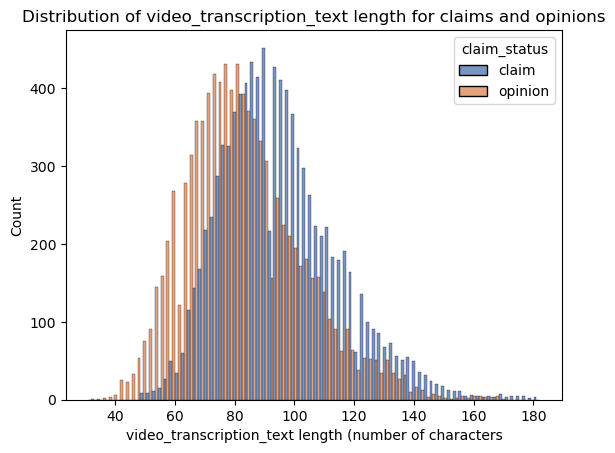

In [222]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot

sns.histplot(data=df, stat='count', multiple='dodge', x='text_length',
             kde=False, palette="deep", hue="claim_status",
             element="bars", legend=True)
plt.xlabel('video_transcription_text length (number of characters')
plt.title('Distribution of video_transcription_text length for claims and opinions')
plt.show()

Character count distribution for opinion and claim videos are both approximately normal with a slight right skew. 

**Feature selection and transformation**

Encode target and catgorical variables.

In [49]:
# Create a copy of the X data
X = df.copy()

# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)

# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})

# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()


,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


Target variable `claim_status`:
- 0 represents an opinion
- 1 representy a claim

### **Split the data**

In [52]:
# Isolate target variable
y = X['claim_status']

Isolate the features.

In [54]:
# Isolate features
X = X.drop(['claim_status', 'video_transcription_text'], axis=1)

# Display first few rows of features dataframe
X.head()


,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### **Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [57]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [59]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [61]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 10), (3817, 10), (3817, 10), (11450,), (3817,), (3817,))

The number of features (`11`) aligns between the training and testing sets.

The number of rows aligns between the features and the outcome variable for training (`11,450`) and both validation and testing data (`3,817`).

### **Build models**


### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [66]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }


# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

This cell might take several minutes to run. 

In [68]:
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'accuracy', 'precision', 'f1', 'recall'})

In [69]:
# Examine best recall score
rf_cv.best_score_

0.9908534395531852

In [70]:
# Examine best parameters 
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

This model performs exceptionally well, with an average recall score of 0.991. A recall score of 0.991 means that the model correctly identified 99.1% of all actual _claims_ in the data set. Even with an excellent average recall score, it is crucial to further evaluate the model to be sure that it does not simply classify all sampels as claims. 

For a comprehensive anaylsis, an XGBoost model should be built in addition to the random forest model. 

After building the XGBoost model, we will build a classification report and a confusion matrix to identify the champion model. 

### **Build an XGBoost model**

In [74]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [75]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 9min 8s
Wall time: 1min 52s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'accuracy', 'precision', 'f1', 'recall'})

In [76]:
# Examine best score
xgb_cv.best_score_

0.9898176171763818

In [77]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

The XGBoost model also performs exceptionally well, with an average recall score of 0.989. A recall score of 0.989 means that the model correctly identified 98.9% of all actual _claims_ in the data set.

The average recall score for the random forest and XGBoost model are very similar, with the random forest model scoring slightly higher. In the next steps, the models will be evaluated further to identify which model predicts `claim_status` best. 

## **PACE: Execute**

### **Evaluate model**

Evaluate models against validation criteria.

#### **Random forest**

In [82]:
# Use the random forest "best estimator" model to get predictions on the encoded testing set
y_pred = rf_cv.best_estimator_.predict(X_val)

Display the predictions on the encoded testing set.

In [84]:
# Display the predictions on the encoded testing set
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

Display the true labels of the testing set.

In [86]:
# Display the true labels of the testing set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model.

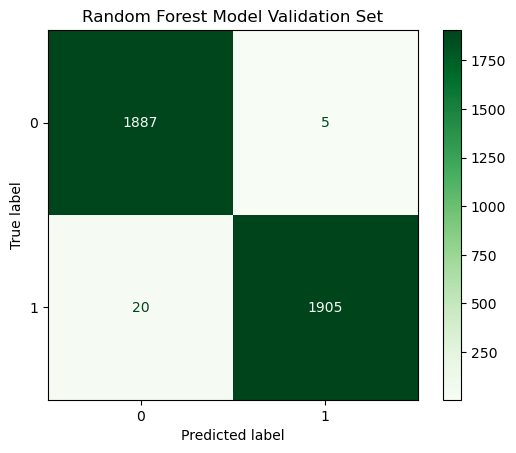

In [88]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot(cmap=plt.cm.Greens)

# Display plot
plt.title('Random Forest Model Validation Set')
plt.show()

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [166]:
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Evaluation**

The **confusion matrix** represents the actual versus predicted class labels and provides a summary for the random forest model's 
- true positives (1905),
- false positives (5),
- true negatives (1887) and
- false negative predictors (20).

The number of true positives means, that 1905 TikTok videos were accurately classified as _opinion_, while the number of true negatives shows that 1887 videos were rightly classified as a _claim_. 20 videos were classified as an _opinion_ when they should have been classified as a _claim_. 5 videos were classified as a _claim_ when they should have beeen classified as an _opinion_.


The **classification report** above shows that the random forest precision, recall, and F1-score are exceptionally high (0.99 or higher), indicating an outstanding level of accuracy and effectiveness in the model's prediction of the target variable `claim_status`.

In the next step, we will evaluate the XGBoost model. 

#### **XGBoost**

In [93]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val)

In [94]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [95]:
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

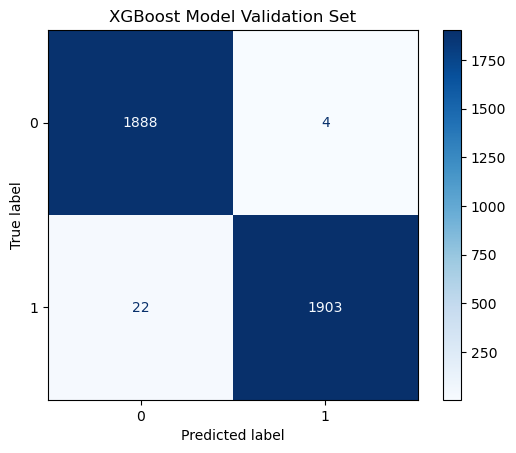

In [96]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot(cmap=plt.cm.Blues)

# Display plot
plt.title('XGBoost Model Validation Set')
plt.show()


In [97]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Evaluation**

The **confusion matrix** represents the actual versus predicted class labels and provides a summary for the XGBoost model's 
- true positives (1903),
- false positives (4),
- true negatives (1888) and
- false negative predictors (22).

The number of true positives means, that 1903 TikTok videos were accurately classified as _opinion_, while the number of true negatives shows that 1888 videos were rightly classified as a _claim_. 22 videos were classified as an _opinion_ when they should have been classified as a _claim_. 4 videos were classified as a _claim_ when they should have beeen classified as an _opinion_.


Similarly to the random forest model, the **classification report** for the XGBoost model shows that the recall, and F1-score are exceptionally high (0.99 or higher).

#### Identifying champinn model

As previously outlined, the model's ability to minimize false negatives is crucial, as misclassifying a _claim_ as an _opinion_ may result in a violation of TikTok's terms of service going unnoticed. 

Despite both models achieving high scores, the XGBoost model produced 22 false negatives, while the random forest model produced 20. Although the difference appears slight, prioritizing the avoidance of false negatives dictates the selection of the random forest model for subsequent steps.

### **Use champion model to predict on test data**

In [181]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test)

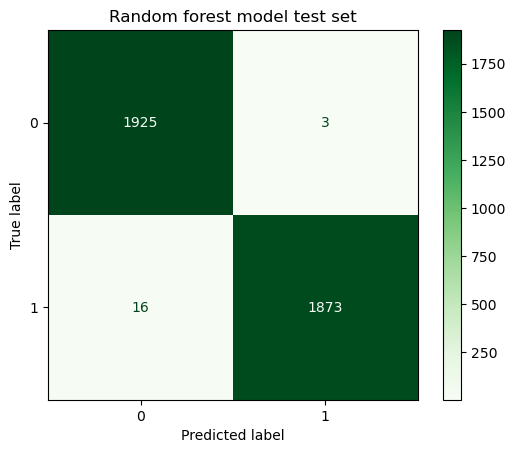

In [183]:
# Compute values for confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)

# Plot confusion matrix
cm_disp.plot(cmap=plt.cm.Greens)

# Display plot
plt.title('Random forest model test set');
plt.show()

To identify the features that have the most influence on the model's decision-making process, the feature importances for the random forest model will be visualized in the next step. 

#### **Feature importances of champion model**


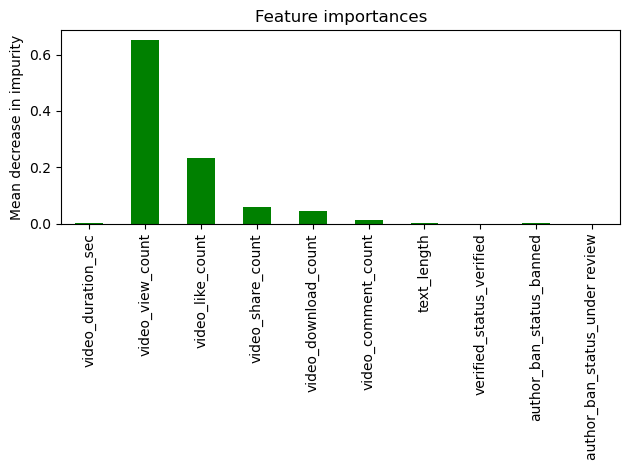

In [199]:
# Identify most predicitve features 
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax, color='green')
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

`video_view_count`, `video_like_count`, `video_share_count`, and `video_download_count` are most influential in improving the model's accuracy, with `video_view_count` and `video_like_count` bein particularly important. 

The most predictive features are all related to the engagement generated by the video. 

### **Conclusion**


The random forest model's most predictive features were all related to the user engagement associated with each video, including views, likes, shares and downloads. This information is used to classify TikTok videos as either a _claim_ or an _opinion_. The model demonstrates excellent precision, recall, and F1-score, indicating its accurate and effective prediction capabilities.

However, as shown in the confusion matrix above, the model still misclassified 16 videos as _opinions_, posing a risk for _claim_ videos that may conflict with TikTok's policies and terms of use remaining undetected.

One variable not included in the analysis is the `video_transcription_text` due to its text-based nature. To address this, the `scikit-learn` bag-of-words algorithm `CountVectorizer` can be used to extract numerical features from the text. This algorithm tokenizes the text by splitting it into n-grams, providing a way to gain further insights and potentially reduce the model's false-negative score.

Additionally, having the number of times a video was reported and the total number of user reports for each author would be valuable additions to the datase.
